In [82]:
import ROOT
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import numpy as np
import array
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.stats import norm, median_absolute_deviation
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import matplotlib.transforms as mtransforms
from itertools import groupby
from operator import itemgetter
from scipy import stats
import re

In [2]:
#Opening .root file and creating dataframes from it's TTrees
file = uproot.open("data/digi_00000154.root")
dataframes = {}

for key in file.keys():
    if isinstance(file[key], uproot.behaviors.TTree.TTree):
        tree = file[key]
        df = tree.arrays(library="pd")
        dataframes[key] = df.astype(int)

In [3]:
#Delete unused columns and create df for work
dataframes['outputtree;1'].drop(["orbitNumber", "bunchCounter", "runParameter", "pulse_stretch", "slot", "OH", "CH", "digiDirection"], axis=1, inplace=True)
dataframes['outputtree;2'].drop(["orbitNumber", "bunchCounter", "runParameter", "pulse_stretch", "slot", "OH", "CH", "digiDirection"], axis=1, inplace=True)
df = dataframes['outputtree;2']
df = df.reset_index()
df.drop(["subentry", "eventCounter"], axis=1, inplace=True)

In [ ]:
# Plotting heatmap for digiBX for each Eta within a chamber
def plot_ocp_BX_eta(df, digiChamber):
    # Filter dataframe by digiChamber
    df_chamber = df[df['digiChamber'] == digiChamber]
    
    # Get unique values for digiEta and digiBX
    unique_digiEta = sorted(list(df_chamber['digiEta'].unique()))
    unique_digiBX = sorted(list(df_chamber['digiBX'].unique()))

    # Create empty 2D array to hold counts
    counts = np.zeros((len(unique_digiBX), len(unique_digiEta)))

    # Fill counts array with number of entries for each digiEta and digiBX
    for idx_eta, digiEta in enumerate(unique_digiEta):
        for idx_bx, digiBX in enumerate(unique_digiBX):
            counts[idx_bx, idx_eta] = len(df_chamber[(df_chamber['digiEta'] == digiEta) & (df_chamber['digiBX'] == digiBX)])

    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(counts, cmap='hot', norm=colors.LogNorm(vmin=counts.min()+1, vmax=counts.max()))

    # Set x and y labels
    ax.set_xticks(range(len(unique_digiEta)))
    ax.set_xticklabels(unique_digiEta)
    ax.set_yticks(range(len(unique_digiBX)))
    ax.set_yticklabels(unique_digiBX)

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax, label='Entries')
    plt.xlabel('digiEta')
    plt.ylabel('digiBX')


    # Set title
    ax.set_title(f'Heatmap for digiChamber {digiChamber}')

    # Show plot
    plt.show()

# Plot heatmaps for all digiChambers
for i in range(0, 4):
    plot_ocp_BX_eta(df, i)

In [ ]:
# Plotting heatmap for digiBX for each strip within a chamber\eta
def plot_ocp_BX_strip(df, digiChamber, digiEta):
    # Filter dataframe by digiChamber and digiEta
    df_filtered = df[(df['digiChamber'] == digiChamber) & (df['digiEta'] == digiEta)]
    
    # Get unique values for digiStrip and digiBX
    unique_digiStrip = sorted(list(df_filtered['digiStrip'].unique()))
    unique_digiBX = sorted(list(df_filtered['digiBX'].unique()))

    # Create empty 2D array to hold counts
    counts = np.zeros((len(unique_digiBX), len(unique_digiStrip)))

    # Fill counts array with number of entries for each digiStrip and digiBX
    for idx_strip, digiStrip in enumerate(unique_digiStrip):
        for idx_bx, digiBX in enumerate(unique_digiBX):
            counts[idx_bx, idx_strip] = len(df_filtered[(df_filtered['digiStrip'] == digiStrip) & (df_filtered['digiBX'] == digiBX)])

    # Create heatmap
    fig, ax = plt.subplots(figsize=(20, 5)) 
    im = ax.imshow(counts, cmap='hot', norm=colors.LogNorm(vmin=counts.min()+1, vmax=counts.max()), aspect=10)

    # Set x and y labels
    ax.set_xticks(range(len(unique_digiStrip)))
    ax.set_xticklabels(unique_digiStrip if len(unique_digiStrip) <= 20 else [s if i % 10 == 0 else '' for i, s in enumerate(unique_digiStrip)], rotation=90)  # Rotate labels and show only every 10th label if there are more than 20 labels
    ax.set_yticks(range(len(unique_digiBX)))
    ax.set_yticklabels(unique_digiBX)
    plt.xlabel('digiStrip')
    plt.ylabel('digiBX')

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax, label='Entries')

    # Set title
    ax.set_title(f'Heatmap for digiChamber {digiChamber}, digiEta {digiEta}')

    # Show plot
    plt.show()
plot_ocp_BX_strip(df, 1, 3)

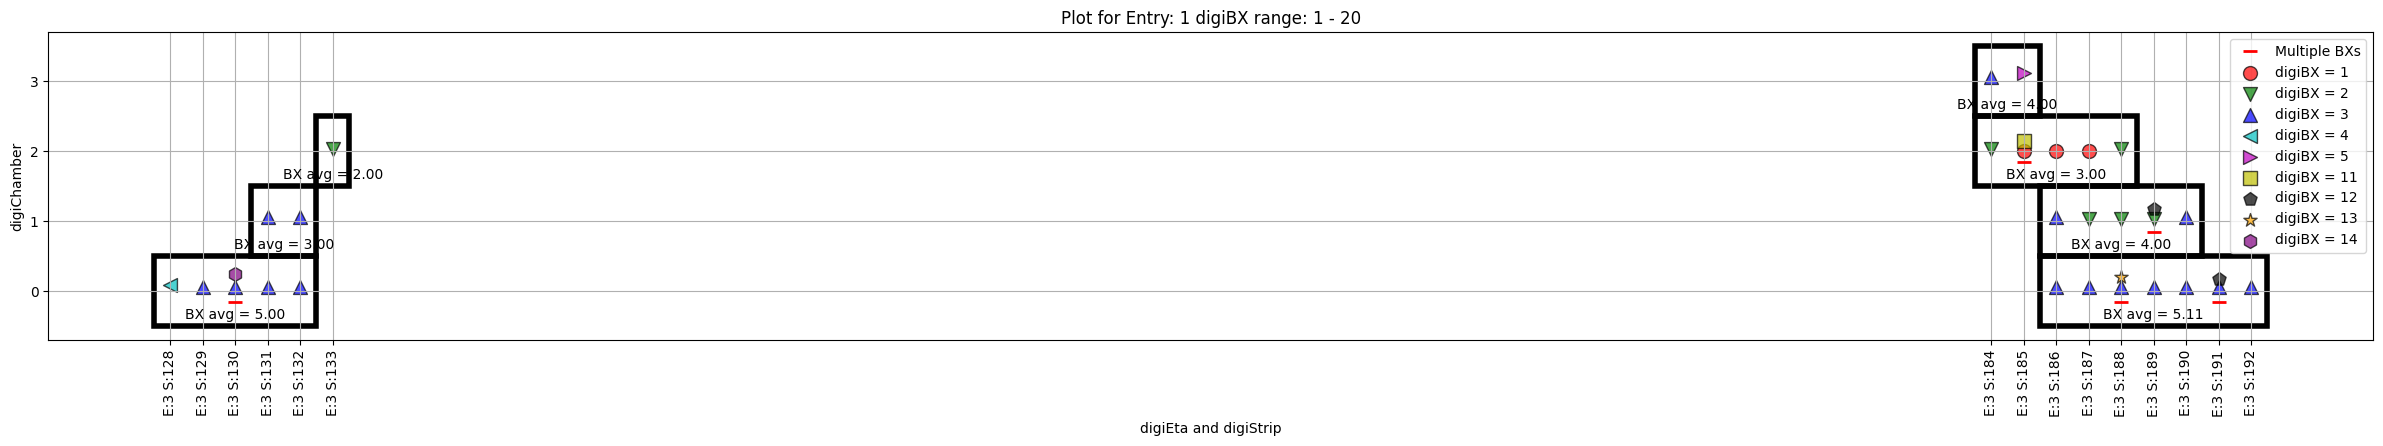

In [6]:
# Display event.
def plot_event(df: pd.DataFrame, entry: int, bx_range: tuple = None) -> None:
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'gray', 'cyan', 'lime', 'maroon', 'navy']
    markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'D', '+', 'x', 'd', '|', '_']

    # Filter dataframe by entry and digiBX range
    if bx_range is None:
        df_entry = df[df['entry'] == entry]
    else:
        min_bx, max_bx = bx_range
        df_entry = df[(df['entry'] == entry) & (df['digiBX'] >= min_bx) & (df['digiBX'] <= max_bx)]
    
    # Add a cluster column based on chamber, eta and strip sequence
    df_entry = df_entry.sort_values(['digiChamber', 'digiEta', 'digiStrip'])
    df_entry['cluster'] = (df_entry['digiChamber'].ne(df_entry['digiChamber'].shift()) | 
                           df_entry['digiEta'].ne(df_entry['digiEta'].shift()) | 
                           ~df_entry['digiStrip'].diff().isin([0,1])).cumsum()

    fig, ax = plt.subplots(figsize=(30, 4))
    
    unique_digi_bx = sorted(list(df_entry['digiBX'].unique()))
    bx_offset_scale = 0.03

    for idx, digi_bx in enumerate(unique_digi_bx):
        df_bx = df_entry[df_entry['digiBX'] == digi_bx]
        color = colors[idx % len(colors)]
        marker = markers[idx % len(markers)]
        
        ax.scatter(df_bx['digiStrip'], df_bx['digiChamber'] + idx * bx_offset_scale, c=color, 
                   marker=marker, s=100, edgecolor='black', linewidth=1, 
                   label=f'digiBX = {digi_bx}', alpha=0.7)

    # Find locations with multiple BXs
    multi_bx_locations = df_entry.groupby(['digiChamber', 'digiEta', 'digiStrip']).filter(lambda x: len(x) > 1)
    multi_bx_locations = multi_bx_locations[['digiChamber', 'digiEta', 'digiStrip']].drop_duplicates()

    # Plot lines for multiple BXs
    for _, row in multi_bx_locations.iterrows():
        ax.plot(row['digiStrip'], row['digiChamber'] -0.15, marker='_', markersize=10, markeredgewidth=2, color='red')
    handles, labels = ax.get_legend_handles_labels()
    # Add legend for multiple BXs
    if not multi_bx_locations.empty:
        handles, labels = ax.get_legend_handles_labels()
        labels.append('Multiple BXs')
        handles.append(Line2D([0], [0], marker='_', color='red', label='Multiple BXs',markeredgewidth=2, markersize=10, linestyle='None'))

    # Sort legend
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0].split('=')[1].strip()) if t[0] != 'Multiple BXs' else -1))
    ax.legend(handles, labels)

    # Display cluster rectangles and average digiBX
    cluster_df = df_entry.groupby('cluster').agg({'digiChamber': 'first', 'digiEta': ['min', 'max'], 
                                                  'digiStrip': ['min', 'max'], 'digiBX': 'mean'}).reset_index()

    for _, row in cluster_df.iterrows():
        rectangle = patches.Rectangle((row[('digiStrip', 'min')]-0.5, row[('digiChamber', 'first')]-0.5), 
                              row[('digiStrip', 'max')] - row[('digiStrip', 'min')]+1, 1, 
                              linewidth=4, edgecolor='black', facecolor='none')
        ax.add_patch(rectangle)
        ax.text((row['digiStrip']['min'] + row['digiStrip']['max']) / 2, row['digiChamber'] -0.4, 
                f"BX avg = {row['digiBX']['mean']:.2f}", horizontalalignment='center')

    plt.yticks(range(0, 4))
    unique_x_labels = df_entry[['digiEta', 'digiStrip']].drop_duplicates()
    ax.set_xticks(unique_x_labels['digiStrip'])
    ax.set_xticklabels(['E:{} S:{}'.format(eta, strip) for eta, strip in zip(unique_x_labels['digiEta'], unique_x_labels['digiStrip'])], rotation=90)


    plt.xlabel('digiEta and digiStrip')
    plt.ylabel('digiChamber')
    plt.title('Plot for Entry: {}'.format(entry) + ('' if bx_range is None else f' digiBX range: {min_bx} - {max_bx}'))
    plt.grid(True)
    plt.show()

plot_event(df, 1, bx_range=(1, 20))

In [ ]:
# Create a dataframe for clusters
def create_cluster_df(df: pd.DataFrame, entry_range: tuple = None, bx_range: tuple = None, filename: str = 'cluster.root') -> None:
    # If entry range is provided, filter dataframe by entry range
    if entry_range:
        df = df[(df['entry'] >= entry_range[0]) & (df['entry'] <= entry_range[1])]
    
    # If BX range is provided, filter dataframe by BX range
    if bx_range:
        df = df[(df['digiBX'] >= bx_range[0]) & (df['digiBX'] <= bx_range[1])]
    
    # Sort values by 'entry', 'digiChamber', 'digiEta', 'digiStrip'
    df = df.sort_values(['entry', 'digiChamber', 'digiEta', 'digiStrip'])

    # Define a function for creating clusters within a group
    def cluster_group(g):
        g['digiCluster'] = (g['digiChamber'].ne(g['digiChamber'].shift()) | 
                            g['digiEta'].ne(g['digiEta'].shift()) | 
                            ~g['digiStrip'].diff().isin([0,1])).cumsum()
        return g

    # Apply the cluster_group function to each 'entry' group
    df = df.groupby('entry').apply(cluster_group)

    def second_smallest(series):
        if len(series) < 2:
            return series.nsmallest(1).iloc[-1]
        else:
            return series.nsmallest(2).iloc[-1]
    def second_largest(series):
        if len(series) < 2:
            return series.nlargest(1).iloc[-1]
        else:
            return series.nlargest(2).iloc[-1]

    cluster_df = df.groupby(['digiCluster', 'entry']).agg({
        'digiBX': ['mean', 'min', 'max', second_smallest, second_largest],
        'digiStrip': ['mean', 'min', 'max'],
        'digiChamber': 'first',
        'digiEta': 'first'
    }).reset_index()
    cluster_df.columns = ['_'.join(col) for col in cluster_df.columns]
    # Create a ROOT file
    root_file = ROOT.TFile(filename, "RECREATE")

    # Create a tree
    tree = ROOT.TTree("cluster", "cluster")

    # Define variables to hold the values for each branch
    data = {column: array.array('d', [0]) for column in cluster_df.columns}

    # Create the branches
    for column in cluster_df.columns:
        tree.Branch(column, data[column], f"{column}/D")

    # Fill the tree
    for i in range(cluster_df.shape[0]):
        for column in cluster_df.columns:
            data[column][0] = cluster_df.at[i, column]
        tree.Fill()

    # Write the tree into the ROOT file and close it
    tree.Write()
    root_file.Close()


# Usage:
create_cluster_df(df, bx_range = (0, 7), filename = 'data/cluster.root')
# file = uproot.open("data/cluster.root")
# dataframes_cluster = {}

# for key in file.keys():
#     if isinstance(file[key], uproot.behaviors.TTree.TTree):
#         tree = file[key]
#         df_clus = tree.arrays(library="pd")
#         dataframes_cluster[key] = df_clus.astype(float)
# df_cluste2=dataframes_cluster['cluster;1']


In [209]:
def create_cluster_df(df: pd.DataFrame, entry_range: tuple = None, bx_range: tuple = None) -> None:
    # If entry range is provided, filter dataframe by entry range
    if entry_range:
        df = df[(df['entry'] >= entry_range[0]) & (df['entry'] <= entry_range[1])]
    
    # If BX range is provided, filter dataframe by BX range
    if bx_range:
        df = df[(df['digiBX'] >= bx_range[0]) & (df['digiBX'] <= bx_range[1])]
    
    # Sort values by 'entry', 'digiChamber', 'digiEta', 'digiStrip'
    df = df.sort_values(['entry', 'digiChamber', 'digiEta', 'digiStrip'])

    # Define a function for creating clusters within a group
    def cluster_group(g):
        g['digiCluster'] = (g['digiChamber'].ne(g['digiChamber'].shift()) | 
                            g['digiEta'].ne(g['digiEta'].shift()) | 
                            ~g['digiStrip'].diff().isin([0,1])).cumsum()
        return g

    # Apply the cluster_group function to each 'entry' group
    df = df.groupby('entry').apply(cluster_group)

    def second_smallest(series):
        if len(series) < 2:
            return series.nsmallest(1).iloc[-1]
        else:
            return series.nsmallest(2).iloc[-1]
    def second_largest(series):
        if len(series) < 2:
            return series.nlargest(1).iloc[-1]
        else:
            return series.nlargest(2).iloc[-1]

    cluster_df = df.groupby(['digiCluster', 'entry']).agg({
        'digiBX': ['mean', 'min', 'max', second_smallest, second_largest],
        'digiStrip': ['mean', 'min', 'max'],
        'digiChamber':  'first',
        'digiEta': 'first'
    }).reset_index()

    cluster_df.columns = ['_'.join(col) for col in cluster_df.columns]
    cluster_df.rename(columns={'digiCluster_': 'digiCluster', 'entry_': 'entry', 'digiChamber_first': 'digiChamber', 'digiEta_first': 'digiEta'}, inplace=True)
    cluster_df['BX_mean_rounded'] = cluster_df['digiBX_mean'].round(0).astype(int)
    
    return cluster_df

# Usage:
df_cluster = create_cluster_df(df, bx_range = (0, 7))

/var/folders/nw/8dk2cczn3fdbjmqybvvdjykc0000gn/T/ipykernel_11728/617315055.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('entry').apply(cluster_group)


In [210]:
# Filter out dataframe for only good events
def find_good_events(df_cluster):
    df = df_cluster
    # Group by event and chamber, and count the number of clusters in each chamber
    cluster_counts = df.groupby(['entry', 'digiChamber'])['digiCluster'].count()
    
    # Check if there is exactly one cluster in each chamber for each event
    good_events = cluster_counts.groupby('entry').apply(lambda x: all(x == 1))
    
    # Add column for good/bad event
    df['good_event'] = good_events[df['entry']].values
    
    # Add column for average BX
    df['avg_event_BX'] = df.groupby('entry')['digiBX_mean'].transform('mean')
    
    return df

# Example usage
df_cluster_good_events = find_good_events(df_cluster)

Slope: -0.5, Intercept: 71.125
Average BX: 2.875


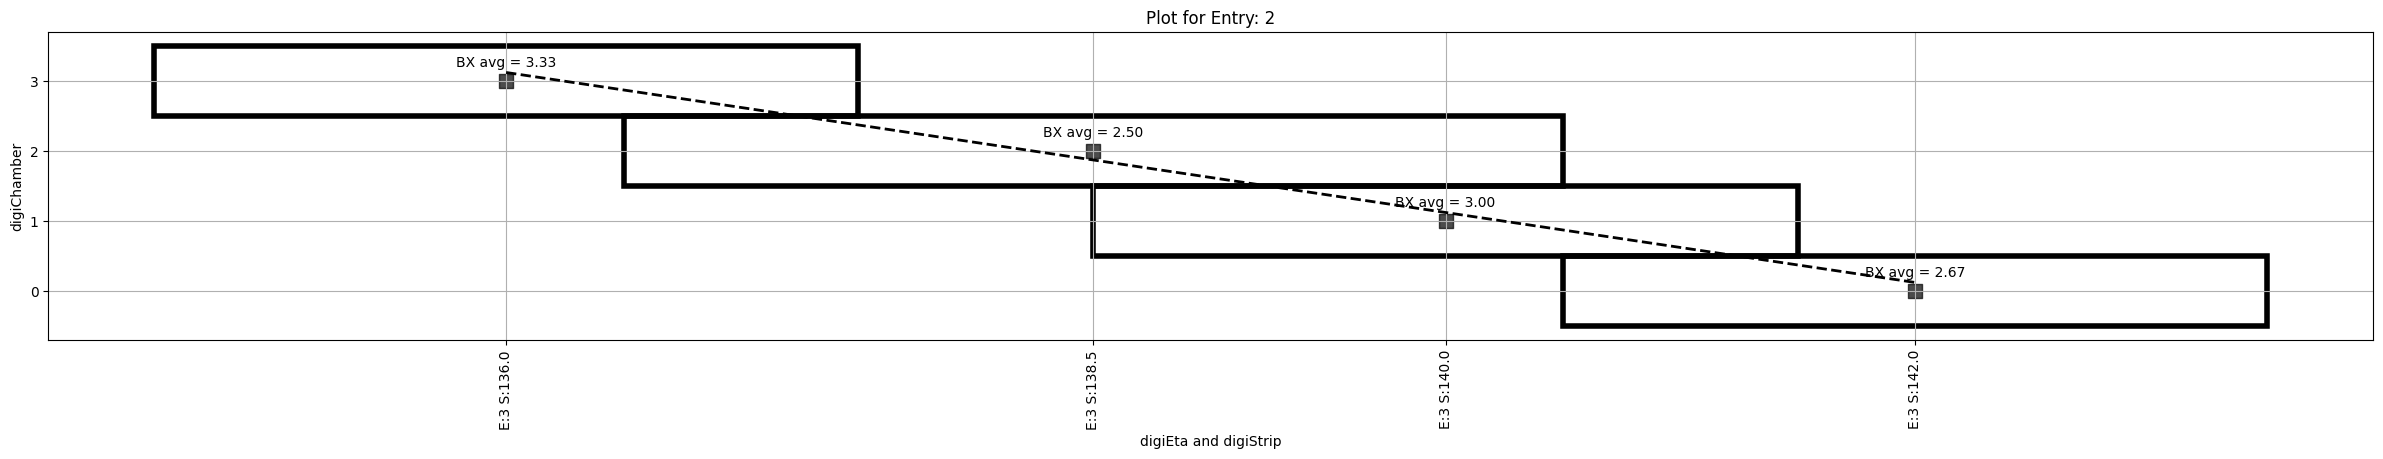

In [18]:
# Plot linear cluster fit for event
def plot_cluster(df, event):
    # Filter dataframe by event
    df_event = df[df['entry'] == event]

    # Prepare data for plotting and fitting
    x = df_event['digiStrip_mean']
    y = df_event['digiChamber']

    # Fit the points to a line
    slope, intercept, _, _ = stats.theilslopes(y, x, 0.95) # Theil-Sen estimator
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = slope * x_fit + intercept

    # Plot style configuration
    fig, ax = plt.subplots(figsize=(30, 4))

    for idx, row in df_event.iterrows():
        ax.scatter(row['digiStrip_mean'], row['digiChamber'], c='black', 
                   marker='s', s=100, edgecolor='black', linewidth=1,
                   alpha=0.7)
        rectangle = patches.Rectangle((row['digiStrip_min']-0.5, row['digiChamber']-0.5), 
                                      row['digiStrip_max'] - row['digiStrip_min']+1, 1, 
                                      linewidth=4, edgecolor='black', facecolor='none')
        ax.add_patch(rectangle)
        ax.text(row['digiStrip_mean'], row['digiChamber'] + 0.2, 
                f"BX avg = {row['digiBX_mean']:.2f}", horizontalalignment='center')

    # Plot fitted line
    ax.plot(x_fit, y_fit, color='black', linewidth=2, linestyle='--')

    plt.yticks(range(0, 4))
    ax.set_xticks(df_event['digiStrip_mean'])
    ax.set_xticklabels([f"E:{row['digiEta']} S:{row['digiStrip_mean']}" for _, row in df_event.iterrows()], rotation=90)

    plt.xlabel('digiEta and digiStrip')
    plt.ylabel('digiChamber')
    plt.title(f'Plot for Entry: {event}')

    # Print fitting parameters
    print(f"Slope: {slope}, Intercept: {intercept}")

    # Print average BX
    avg_bx = df_event['digiBX_mean'].mean()
    print(f"Average BX: {avg_bx}")

    plt.grid(True)
    plt.show()
plot_cluster(df_cluster_good_events, 2)

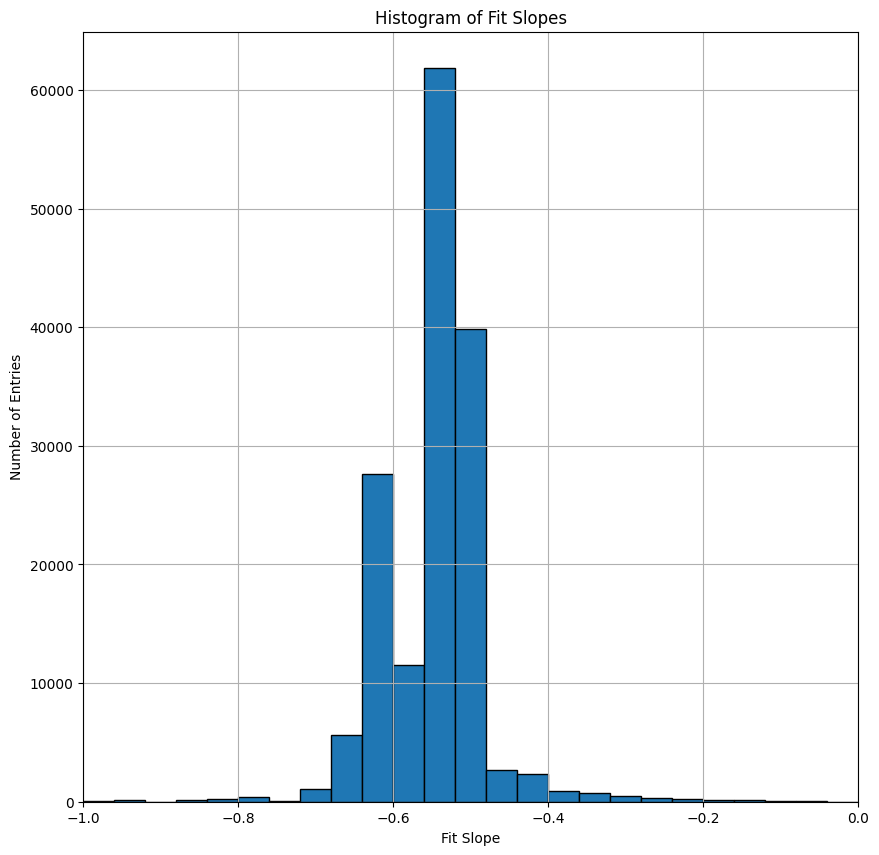

In [22]:
def plot_fit_slopes(df_cluster_good_events):
    df = df_cluster_good_events
    # Plot fit slopes bin histogram
    def calculate_slope(df):
        slopes = []
        # Choose god events
        df = df[df['good_event'] == True]

        # Group by event
        grouped = df.groupby('entry')

        for name, group in grouped:
            
            x = group['digiStrip_mean'].values
            y = group['digiChamber'].values
            # Check if there are enough unique points to fit
            if len(np.unique(x)) > 3:
                # Calculate Median Absolute Deviation
                # MAD = stats.median_abs_deviation(y, scale='normal')
                # median = np.median(y)
                # if any(abs(y - median) > 2 * MAD):  # if any y-value is an outlier
                #     continue  # skip this group
                
                slope, intercept, _, _ = stats.theilslopes(y, x, 0.95) # Theil-Sen estimator
                
                slopes.append(slope)
                # if slope < -0.6:
                #     plot_event(df, name)

        return slopes
    # Calculate slopes
    slopes = calculate_slope(df)
    
    # Create histogram
    fig, ax = plt.subplots(figsize=(10, 10))
    
    ax.hist(slopes, bins=100, edgecolor='black')  # Choose a suitable number of bins
    ax.set_xlim(-1, 0)
    ax.set_xlabel('Fit Slope')
    ax.set_ylabel('Number of Entries')
    ax.set_title('Histogram of Fit Slopes')
    plt.grid(True)
    plt.show()
    
plot_fit_slopes(df_cluster_good_events)


/var/folders/nw/8dk2cczn3fdbjmqybvvdjykc0000gn/T/ipykernel_11728/334581009.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_size'] = abs(df['digiStrip_max'] - df['digiStrip_min'])


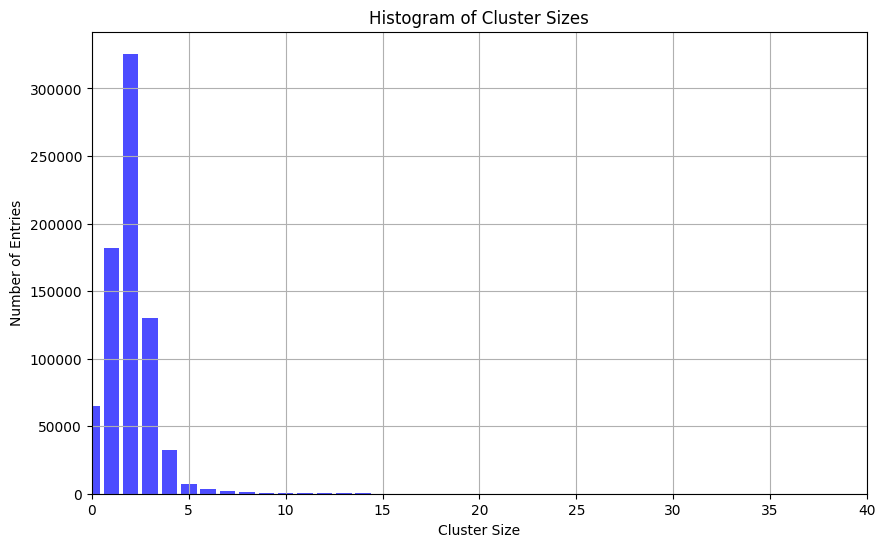

In [23]:
# Plot cluster size bin plot for good events
def plot_cluster_sizes(df_cluster_good_events):
    df = df_cluster_good_events
    df = df[df['good_event'] == True]
    # Calculate the size of each cluster
    df['cluster_size'] = abs(df['digiStrip_max'] - df['digiStrip_min'])

    # Count frequencies of each cluster size
    size_counts = df['cluster_size'].value_counts()

    # Create histogram
    plt.figure(figsize=(10, 6))
    plt.bar(size_counts.index, size_counts.values, color='blue', alpha=0.7)

    plt.title('Histogram of Cluster Sizes')
    plt.xlabel('Cluster Size')
    plt.xlim(0, 40)
    plt.ylabel('Number of Entries')
    plt.grid(True)
    plt.show()

plot_cluster_sizes(df_cluster_good_events)

In [26]:
df_cluster_good_events

,digiCluster,entry,digiBX_mean,digiBX_min,digiBX_max,digiBX_second_smallest,digiBX_second_largest,digiStrip_mean,digiStrip_min,digiStrip_max,digiChamber,digiEta,good_event,avg_event_BX
0,1,0,3.000000,3,3,3,3,5.5,5,6,0,3,False,2.735714
1,1,1,3.200000,3,4,3,3,130.0,128,132,0,3,False,2.714286
2,1,2,2.666667,2,3,3,3,142.0,141,143,0,3,True,2.875000
3,1,3,4.000000,4,4,4,4,46.0,46,46,0,3,True,2.883929
4,1,4,2.333333,2,3,2,2,181.0,180,182,0,4,False,2.613889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647707,285,278145,3.000000,3,3,3,3,216.5,216,217,3,4,False,2.689858
1647708,286,278145,2.250000,2,3,2,2,244.5,243,246,3,4,False,2.689858
1647709,287,278145,2.500000,2,3,3,2,271.5,271,272,3,4,False,2.689858
1647710,288,278145,2.500000,2,3,3,2,302.5,302,303,3,4,False,2.689858


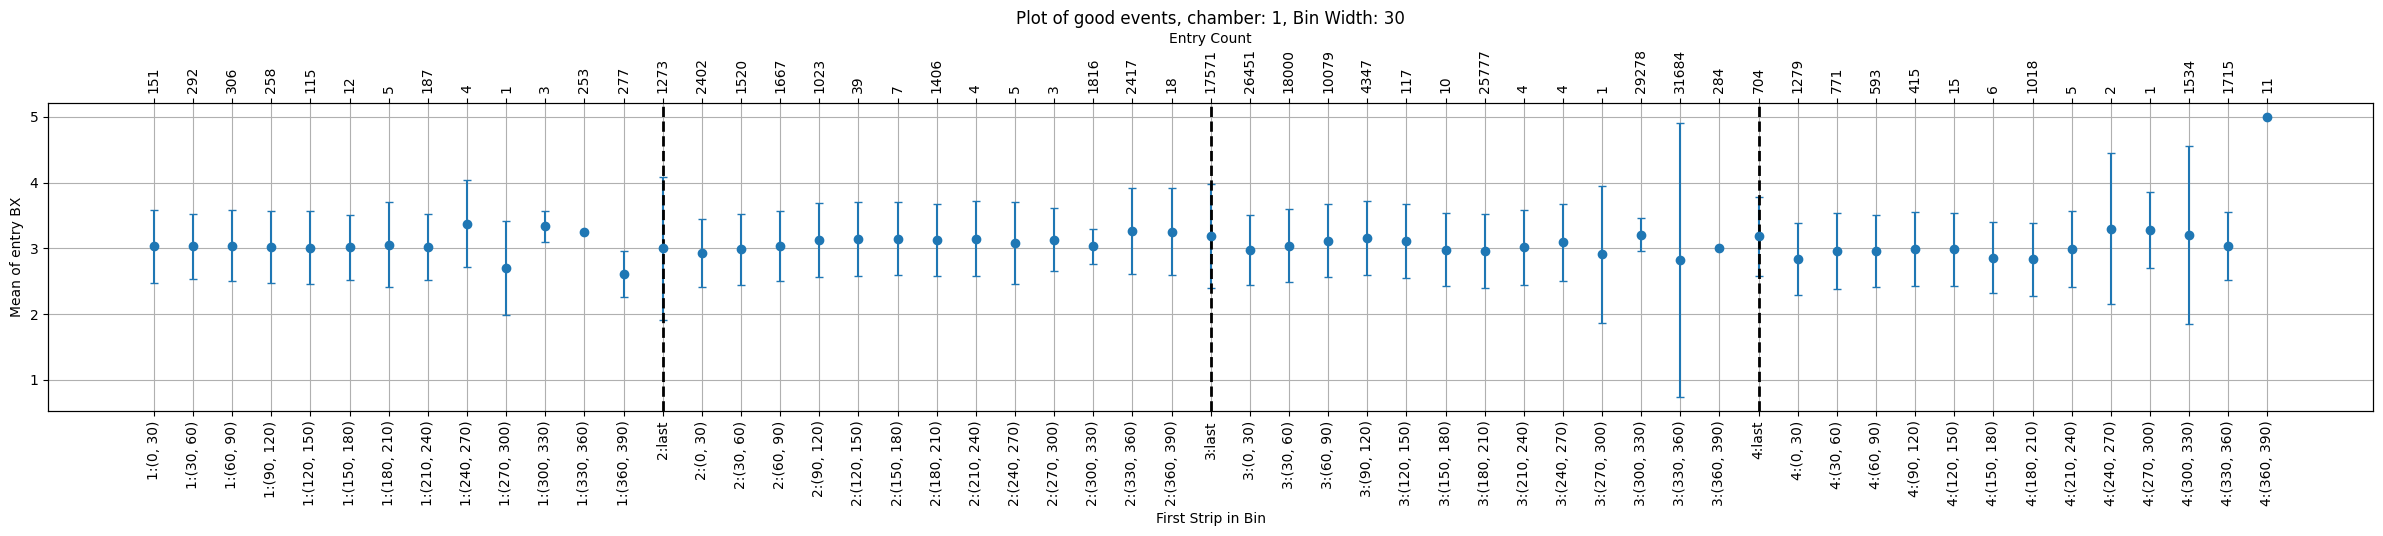

In [212]:
# On X axe we have average digiStrip_mean(which corresponds to CLUSTER) within selected bin width, y - average entry BX.
def plot_good_BX_bin(df, chamber, strip_bin_width, parameter):
    # Filter out events marked as bad
    df = df[df['good_event']].copy()
    df = df[df['digiChamber']==chamber]
    fig, ax = plt.subplots(figsize=(30, 4))
    # Create bins for strip
    df['strip_bin'] = pd.cut(df['digiStrip_mean'], np.arange(0, df['digiStrip_mean'].max() + strip_bin_width, strip_bin_width))

    # Create a combined column for 'digiEta' and 'strip_bin'
    df['eta_strip'] = df['digiEta'].astype(str) + ':' + df['strip_bin'].astype(str)
    
    # Calculate mean and std of avg_BX for each eta_strip bin
    grouped = df.groupby('eta_strip')[parameter].agg(['mean', 'std'])
    
    # We sort the index to maintain the order of Eta and Strip while plotting
    grouped = grouped.sort_index()
    grouped_tmp = grouped.copy()
    grouped = grouped.reset_index(drop=False)
    def sort_eta_strip(dataframe):
        # Extract the numerical part from eta_strip and convert float values to integers
        dataframe['eta_strip'] = dataframe['eta_strip'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
        dataframe['eta_strip'] = dataframe['eta_strip'].apply(lambda x: [int(float(val)) for val in x])
        
        # # Replace 'nan' with 'last'
        # dataframe['eta_strip'] = dataframe['eta_strip'].replace('nan', 'last')
        
        # Sort the DataFrame by eta_strip column
        dataframe.sort_values('eta_strip', inplace=True)
        
        # Convert the sorted integer values back to strings in the format 'x:(a, b]'
        dataframe['eta_strip'] = dataframe['eta_strip'].apply(lambda x: f"{x[0]}:({x[1]}, {x[2]})" if len(x) > 1 else f"{x[0]}:last" if x[0] != 'last' else 'last')
        # dataframe['eta_strip'] = dataframe['eta_strip'].apply(lambda x: f"{x[0]}:({x[1]}, {x[2]})" if len(x) > 1 else f"{x[0]}:{x[0]}" if x[0] != 'last' else 'last')
        
        # Reset the index of the DataFrame
        dataframe.reset_index(drop=True, inplace=True)
        
        return dataframe

    grouped = sort_eta_strip(grouped)
    grouped = grouped.set_index('eta_strip', drop=True)

    # Plot the data with error bars
    plt.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], fmt='o', capsize=3)

    plt.xticks(rotation=90) # This will rotate x-axis labels for better readability
    # plt.yticks(range(0, 4))
    plt.xlabel('First Strip in Bin')
    plt.ylabel('Mean of entry BX')
    plt.title(f'Plot of good events, chamber: {chamber}, Bin Width: {strip_bin_width}')
    plt.grid(True)
    
    # Add bold vertical lines when digiEta changes
    previous_eta = str(1)
    for i, eta_strip in enumerate(grouped.index):
        eta = eta_strip.split(':')[0]
        eta2 = eta_strip.split(':')[1]
        if eta != previous_eta:
            plt.axvline(i, color='k', linestyle='--', linewidth=2)
            previous_eta = eta
    
    # Move the numbers to the x-axis as labels on top
    entry_counts = [df[df['eta_strip'] == eta_strip].shape[0] for eta_strip in grouped_tmp.index]
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim()) 
    ax_top.set_xticks(range(len(grouped.index)))
    ax_top.set_xticklabels(entry_counts, rotation=90)
    ax_top.set_xlabel('Entry Count')
    plt.show()

plot_good_BX_bin(df_cluster_good_events,1, 30, "digiBX_mean")

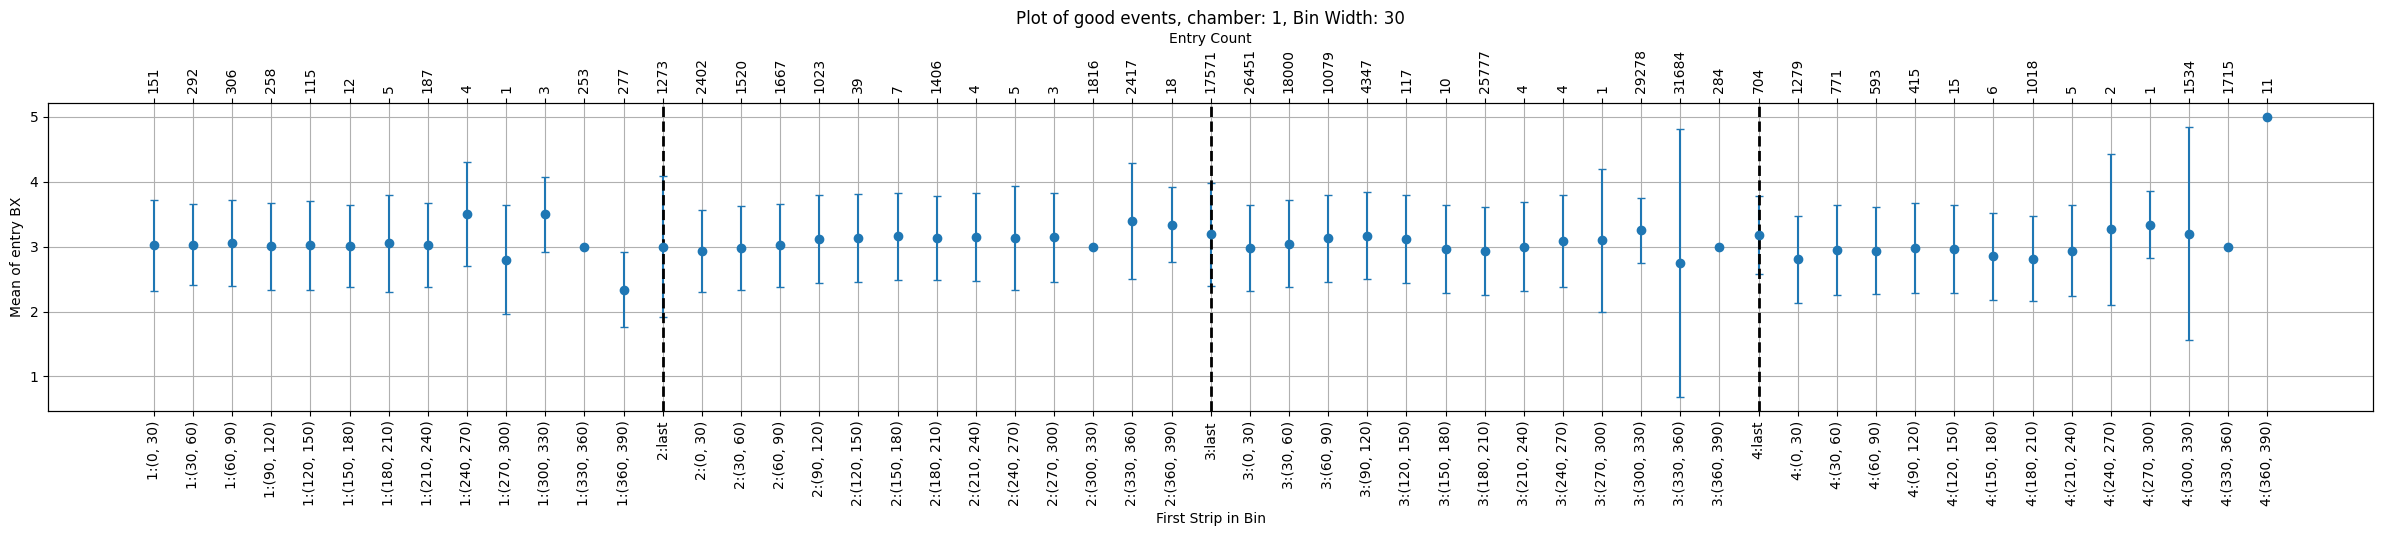

In [213]:
plot_good_BX_bin(df_cluster_good_events,1, 30, "BX_mean_rounded")

/var/folders/nw/8dk2cczn3fdbjmqybvvdjykc0000gn/T/ipykernel_11728/2899790089.py:23: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  std = median_absolute_deviation(finite_values)


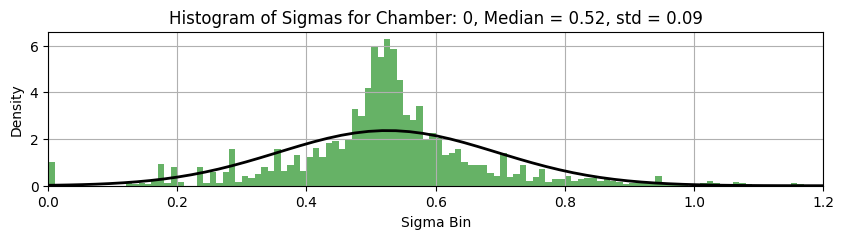

/var/folders/nw/8dk2cczn3fdbjmqybvvdjykc0000gn/T/ipykernel_11728/2899790089.py:23: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  std = median_absolute_deviation(finite_values)


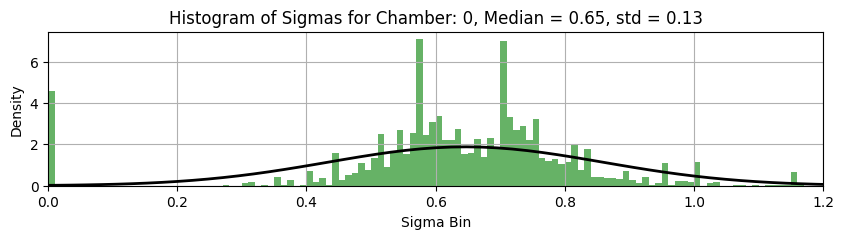

In [221]:
def plot_sigmas_histogram_with_gaussian_fit(df, chamber, sigma_bin_width, parameter):
    # Filter out events marked as bad
    df = df[df['good_event']].copy()
    df = df[df['digiChamber']==chamber]

    # Create a combined column for 'digiEta_first' and 'digiStrip_mean'
    df['eta_strip'] = df['digiEta'].astype(str) + ':' + df['digiStrip_mean'].astype(str)
    
    # Calculate mean and std of avg_BX for each eta_strip bin
    grouped = df.groupby('eta_strip')[parameter].agg(['mean', 'std'])

    # Define the bins according to the sigma_bin_width
    bins = np.arange(grouped['std'].min(), grouped['std'].max(), sigma_bin_width)

    # Create a new column 'sigma_bin' which represents the bin of each 'eta_strip' 
    grouped['sigma_bin'] = pd.cut(grouped['std'], bins=bins)

    # Filter finite values before fit
    finite_values = grouped['std'][np.isfinite(grouped['std'])]

    # Median and std in same units as x-axis
    median = finite_values.median()
    std = median_absolute_deviation(finite_values)

    # Fit a Gaussian to the sigma data
    mu, sigma = norm.fit(finite_values)

    # Plot the histogram
    plt.figure(figsize=(10, 2))
    plt.hist(grouped['std'], bins=bins, density=True, alpha=0.6, color='g')

    # Plot the Gaussian fit
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, sigma)
    plt.plot(x, p, 'k', linewidth=2)
    plt.xlim(0, 1.2)
    plt.title('Histogram of Sigmas for Chamber: '+str(chamber)+', Median = {:.2f}, std = {:.2f}'.format(median, std))
    plt.xlabel('Sigma Bin')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

# Usage
plot_sigmas_histogram_with_gaussian_fit(df_cluster_good_events, 0, 0.01, "digiBX_mean")
plot_sigmas_histogram_with_gaussian_fit(df_cluster_good_events, 0, 0.01, "BX_mean_rounded")


In [232]:
df_cluster_good_events[df_cluster_good_events['entry']==8]

,digiCluster,entry,digiBX_mean,digiBX_min,digiBX_max,digiBX_second_smallest,digiBX_second_largest,digiStrip_mean,digiStrip_min,digiStrip_max,digiChamber,digiEta,BX_mean_rounded,good_event,avg_event_BX
8,1,8,2.750000,2,3,3,3,205.5,204,207,0,3,3,True,3.270833
300240,2,8,2.500000,2,3,2,3,204.5,203,206,1,3,2,True,3.270833
598745,3,8,2.333333,2,3,2,2,203.0,202,204,2,3,2,True,3.270833
895664,4,8,5.500000,5,6,6,5,201.5,201,202,3,3,6,True,3.270833


In [ ]:
def plot_good_events_vs_bad_events(df_processed):
    # Filter out events marked as bad
    df = df_processed
    
    # Calculate the fraction of good events
    fraction = df['good_event'].sum() / df.shape[0]
    
    # Plot the data
    plt.figure(figsize=(8, 4))
    plt.bar(['Good events', 'Bad events'], [fraction, 1-fraction], color=['green', 'red'], alpha=0.7)
    plt.title(f'Fraction of good events: {fraction:.2f}')
    plt.ylabel('Fraction')
    plt.grid(True)
    plt.show()
plot_good_events_vs_bad_events(df_processed)

In [ ]:
def plot_good_events_vs_bad_events_per_chamber(df_processed):
    # Filter out events marked as bad
    df = df_processed
    
    # Group by chamber and calculate the fraction of good events
    grouped = df.groupby('digiChamber_first')['good_event'].agg(['sum', 'count'])
    grouped['fraction'] = grouped['sum'] / grouped['count']
    
    # Plot the data
    plt.figure(figsize=(8, 4))
    plt.bar(grouped.index, grouped['fraction'], color='blue', alpha=0.7)
    plt.title('Fraction of good events per chamber')
    plt.xlabel('Chamber')
    plt.ylabel('Fraction')
    plt.grid(True)
    plt.show()
plot_good_events_vs_bad_events_per_chamber(df_processed)